# (E6) Autoencoders
In this exercise, you will be given an example of [autoencoders](https://en.wikipedia.org/wiki/Autoencoder). 
You should be able to replicate the results given here if you have completed (E2)-(E5) correctly.

It would be best if you have a Python IDE (integrated development environment) such as [PyCharm](https://www.jetbrains.com/pycharm/) and [Anaconda](anaconda.com) is installed because they will make your life easier! If not, you may want to work on the assignment using Google Colab. In any cases, what you need to do is 1) to fill in the blanks in .py files; and 2) to import the files (e.g., layer.py, optim.py, model.py, etc) that you have completed for use. Here are some scenarios how you would go about doing the assignment: 

#### Without Google Colab: Python IDE + Anaconda 
If you have a Python IDE and Anaconda installed, you can do one of the following:
- Edit .py files in the IDE. Then, simply open .ipynb file also in the IDE where you can edit and run codes. 
- Your IDE might not support running .ipynb files. However, since you have installed Anaconda, you can just open this notebook using Jupyter Notebook.

In both of these cases, you can simply import .py files in this .ipynb file:
```python
from model import NeuralNetwork
```
 
#### With Google Colab
- Google Colab has an embedded code editor. So, you could simply upload all .py files to Google Colab and edit the files there. Once you upload the files, double click a file that you want to edit. Please **make sure that you download up-to-date files frequently**, otherwise Google Colab might accidentally restart and all your files might be gone.
- If you feel like the above way is cumbersome, you could instead use any online Python editors for completing .py files (e.g., see [repl.it](https://repl.it/languages/python3)). Also, it's not impossible that you edit the files using any text editors, but they don't show you essential Python grammar information, so you'll be prone to make mistakes in that case. Once you are done editing, you can either upload the files to Colab or follow the instruction below. 
 
- If you have *git clone*d the assignment repository to a directory in your Google Drive (or you have the files stored in the Drive anyway), you can do the following:
```jupyterpython
from google.colab import drive
drive.mount('/content/drive/')          # this will direct you to a link where you can get an authorization key
import sys
sys.path.append('/content/drive/My Drive/your-directory-where-the-python-files-exist')
```
Then, you are good to go. When you change a .py file, make sure it is synced to the drive, then you need to re-run the above lines to get access to the latest version of the file. Note that you should give correct path to *sys.path.append* method.

Now, let's get started!
## Autoencoder
### Input and Target
An autoencoder learns the latent embeddings of inputs in an unsupervised way. This is because we do not need to have specific target values associated with the inputs; however, the input data themselves will act as the targets. 

To see it more concretely, let's look at below code which prepares the data for learning an autoencoder. 

In [1]:
from model import NeuralNetwork

In [2]:
import numpy as np
def generate_data(num=8):
    """ Generate 'num' number of one-hot encoded integers. """ 
    x_train = np.eye(num)[np.arange(num)]                       # This is a simple way to one-hot encode integers
    
    # Repeat x_train multiple times for training
    x_train = np.repeat(x_train, 100, axis=0)
    
    # The target is x_train itself!
    x_target = x_train.copy()
    return x_train, x_target    

Clearly, *x_target* is the same as *x_train*. So, what we want to do is to encode 8-bit inputs using 3 hidden nodes, which in turn will be decoded back to the original 8-bit value by the decoder. Learning an autoencoder, therefore, means that we train both the encoder weight and the decoder weight. In our example, since we have 3 hidden nodes in a single layer, the encoder weight has *[8, 3]* shape, whereas the decoder weight has *[3, 8]* shape. 

### Training an Autoencoder
Now, let us train an autoencoder with the sigmoid activation function and the cross-entropy loss.

In [3]:
from model import NeuralNetwork
from layer import FCLayer
from activation import Activation
from utils import *
from loss import CrossEntropyLoss
from optim import SGD, Adam, RMSProp
# Load data
num = 8
np.random.seed(10)
x_train, x_target = generate_data(num=num)

In [4]:
# Define a model and add fully-connected and activation layers.
nn = NeuralNetwork()
nn.add(FCLayer(x_train.shape[1], 3, initialization='xavier', uniform=False))
nn.add(Activation(sigmoid, sigmoid_prime))
nn.add(FCLayer(3, x_train.shape[1], initialization='xavier', uniform=False))

In [5]:
nn.layers

## Assigning the Cross Entropy Loss functions to the model

In [6]:
# Define loss: note that CrossEntropyLoss is using the softmax output internally
loss = CrossEntropyLoss()
nn.set_loss(loss)

In [7]:
# Set up hyperparameters
lr = 0.0001
epochs = 2000
freq = epochs // 10
batch_size = 64

In [8]:
nn.parameters()[3].shape

(1, 8)

In [9]:
for i in range(0,len(nn.parameters())):
    print(nn.parameters()[i].shape)


(8, 3)
(1, 3)
(3, 8)
(1, 8)


In [10]:
# Define optimizer and associate it with the model
optimizer = Adam(nn.parameters(), lr=lr)
nn.set_optimizer(optimizer)

In [11]:
# Training begins
inds = list(range(x_train.shape[0]))
N = x_train.shape[0]

loss_hist = []
total_pred_hist = []
total_loss_hist = []
for epoch in range(epochs):
    inds = np.random.permutation(inds)
    x_train = x_train[inds]
    x_target = x_target[inds]
    
    loss = 0
    for b in range(0, N, batch_size):
        #0, 800, 64 
        # get the mini-batch
#         print("b:{}".format(b))
#         print("b+batch_size:{}".format(b+batch_size))
        x_batch = x_train[b: b+batch_size]
#         print("x_batch:{}".format(x_batch))
        x_target_batch = x_target[b: b+batch_size]
        
        # feed forward
#         print(x_batch)
        pred = nn.predict(x_batch)
        total_pred_hist.append(pred)
        #pred = result from forward pass, i.e. H^{l-1}
        
        # Error
        loss += nn.loss(pred, x_target_batch)/N
        total_loss_hist.append(loss)
        #this is the delta from the loss function
        
        # Back propagation of error
        nn.backward(pred, x_target_batch)
        
        # Update parameters
        nn.optimizer.step()
    
    # Record loss per epoch
    loss_hist.append(loss)
    
    if epoch % freq == 0:
        print()
        print("Epoch %d/%d\tloss=%.5f" % (epoch + 1, epochs, loss), end='\t', flush=True)
        
        # Test with the training data
        pred = nn.predict(x_train, mode=False)
        l = nn.loss(pred, x_target)
        print("Test loss: {:.5f}".format(l), end='')

print("\nTraining finished!")
print("Print prediction results:")
x_test = np.eye(num)[np.arange(num)]                        # Test data (one-hot encoded)
np.set_printoptions(2)
for x in x_test:
    print("\tInput: {}\tOutput: {}".format(x, softmax(nn.predict(x[None, :], mode=False))))


Epoch 1/2000	loss=0.03323	Test loss: 2.12953
Epoch 201/2000	loss=0.03392	Test loss: 2.12467
Epoch 401/2000	loss=0.03352	Test loss: 2.00286
Epoch 601/2000	loss=0.03421	Test loss: 2.15461
Epoch 801/2000	loss=0.03402	Test loss: 2.16114
Epoch 1001/2000	loss=0.03388	Test loss: 2.08163
Epoch 1201/2000	loss=0.03372	Test loss: 2.03800
Epoch 1401/2000	loss=0.03380	Test loss: 2.10136
Epoch 1601/2000	loss=0.03377	Test loss: 2.09093
Epoch 1801/2000	loss=0.03383	Test loss: 2.08120
Training finished!
Print prediction results:
	Input: [1. 0. 0. 0. 0. 0. 0. 0.]	Output: [[0.12 0.12 0.13 0.13 0.13 0.13 0.13 0.12]]
	Input: [0. 1. 0. 0. 0. 0. 0. 0.]	Output: [[0.12 0.12 0.13 0.13 0.13 0.13 0.13 0.12]]
	Input: [0. 0. 1. 0. 0. 0. 0. 0.]	Output: [[0.12 0.12 0.13 0.13 0.13 0.13 0.13 0.12]]
	Input: [0. 0. 0. 1. 0. 0. 0. 0.]	Output: [[0.12 0.12 0.13 0.13 0.13 0.13 0.13 0.12]]
	Input: [0. 0. 0. 0. 1. 0. 0. 0.]	Output: [[0.12 0.12 0.13 0.13 0.13 0.13 0.13 0.12]]
	Input: [0. 0. 0. 0. 0. 1. 0. 0.]	Output: [[0.12 0.

If you look at the output values of the network, clearly we have successfully trained the autoencoder to encode-decode 8-bit integers!

## (E7) Your Turn:  Explain the autoencoder
Given the trained model that can encode the 0-7 integers, explain how the NN model learned to encode/compress the numbers. Rather than just stating your reasoning in words, do explore the model closely to see what it has learned. 

$$
loss(x, y) = - \frac{1}{C} * \sum_i y[i] * \log((1 + \exp(-x[i]))^{-1})
                         + (1-y[i]) * \log\left(\frac{\exp(-x[i])}{(1 + \exp(-x[i]))}\right)
                         $$

In [12]:
loss_hist = np.array(loss_hist).astype(float)

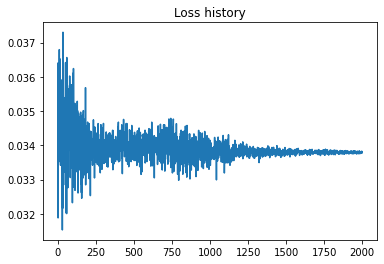

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_hist) # Plot list. x-values assumed to be [0, 1, 2, 3]
plt.title("Loss history")
plt.show() 

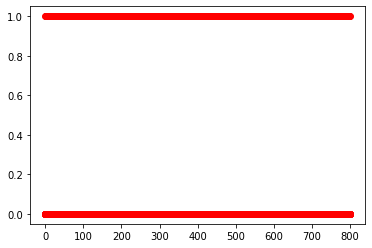

In [14]:
plt.plot(x_train, 'ro')

In [15]:
empty_list = []
for i in range(0, len(x_train)): 
    empty_list.append(int(np.where(x_train[i] ==1)[0]))

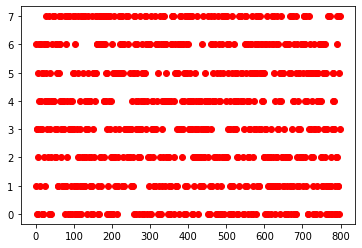

In [16]:
plt.plot(empty_list, 'ro')

(array([100.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,
        100.,   0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,
        100.,   0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,
          0., 100.,   0.,   0.,   0.,   0., 100.]),
 array([0.  , 0.17, 0.35, 0.52, 0.7 , 0.88, 1.05, 1.22, 1.4 , 1.57, 1.75,
        1.92, 2.1 , 2.27, 2.45, 2.62, 2.8 , 2.97, 3.15, 3.32, 3.5 , 3.67,
        3.85, 4.02, 4.2 , 4.38, 4.55, 4.72, 4.9 , 5.07, 5.25, 5.42, 5.6 ,
        5.77, 5.95, 6.12, 6.3 , 6.47, 6.65, 6.82, 7.  ]),
 <a list of 40 Patch objects>)

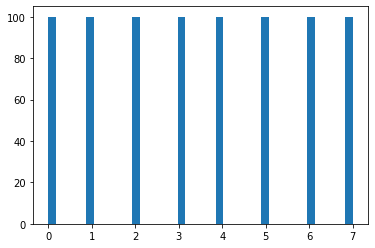

In [17]:
plt.hist(empty_list, bins= 40)

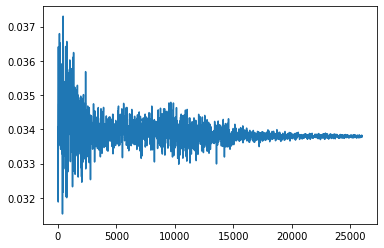

In [18]:
plt.plot(total_loss_hist)